In [1]:
set.seed(42)
train_set = read.delim("data/train_set.txt", sep = " ")
test_set = read.delim("data/test_set.txt", sep = " ")

train_set["rain"] = NULL
train_set["rain_log"] = NULL

test_set["rain"] = NULL
test_set["rain_log"] = NULL

train_set[,"rain_class"] = as.factor(train_set[,"rain_class"])
test_set[,"rain_class"] = as.factor(test_set[,"rain_class"])

In [2]:
exp_var = setdiff(names(train_set), c("rain"))
exp_var

[1] "ff"           "t"            "td"           "hu"           "dd"          
 [6] "precip_log"   "ws_arome"     "p3031_arome"  "u10_arome"    "v10_arome"   
[11] "t2m_arome"    "d2m_arome"    "r_arome"      "tp_arome_log" "msl_arome"   
[16] "rain_class"   "month2"       "month3"       "month4"       "month5"      
[21] "month6"       "month7"       "month8"       "month9"       "month10"     
[26] "month11"      "month12"

In [3]:
MAPE = function(y, y_hat){
    # y = as.numeric(y)
    # y_hat = as.numeric(y_hat)
    mape = 100*mean(abs((y - y_hat)/y))
    return(mape)
}

MSE = function(y, y_hat){
    mse = mean((y - y_hat)**2)
    return(mse)
}

confusion_matrix = function(pred_class, true_class){
    tab = table(pred_class, true_class)
    print("Confusion matrix")
    print(tab)
    acc = sum(diag(tab)) / sum(tab)
    print(paste("Prediction accuracy : ", acc))
}

In [4]:
library(glmnet)
library(Rcpp)
library(ellipse)
library(leaps)
library(MASS)

library(plotly)
library(ggplot2)     
library(gridExtra)   
library(ggfortify)   
library(ggcorrplot) 

library(dplyr)

Loading required package: Matrix

Loaded glmnet 4.1-4


Attaching package: 'ellipse'


The following object is masked from 'package:graphics':

    pairs


Loading required package: ggplot2


Attaching package: 'plotly'


The following object is masked from 'package:ggplot2':

    last_plot


The following object is masked from 'package:MASS':

    select


The following object is masked from 'package:stats':

    filter


The following object is masked from 'package:graphics':

    layout



Attaching package: 'dplyr'


The following object is masked from 'package:gridExtra':

    combine


The following object is masked from 'package:MASS':

    select


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




## 4. Support Vector Machine

In [5]:
x_train = as.matrix(train_set[, exp_var])
x_test = as.matrix(test_set[, exp_var])

y_train = as.factor(train_set[,"rain_class"])
y_test = as.factor(test_set[,"rain_class"])

In [6]:
library(e1071)
library(rpart)

### 4.1. Linear Support Vector Machine Classification

Firstly we will fit a basic SVM model without tuning hyperparameters

In [7]:
linear.svm = svm(rain_class ~ ., data = train_set, type = "C", kernel = 'linear')
summary(linear.svm)


Call:
svm(formula = rain_class ~ ., data = train_set, type = "C", kernel = "linear")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1 

Number of Support Vectors:  471

 ( 203 115 153 )


Number of Classes:  3 

Levels: 
 high_rain low_rain no_rain




    There are too much support vectors in this linear case, it probably means that the data set is not linearly seperable.

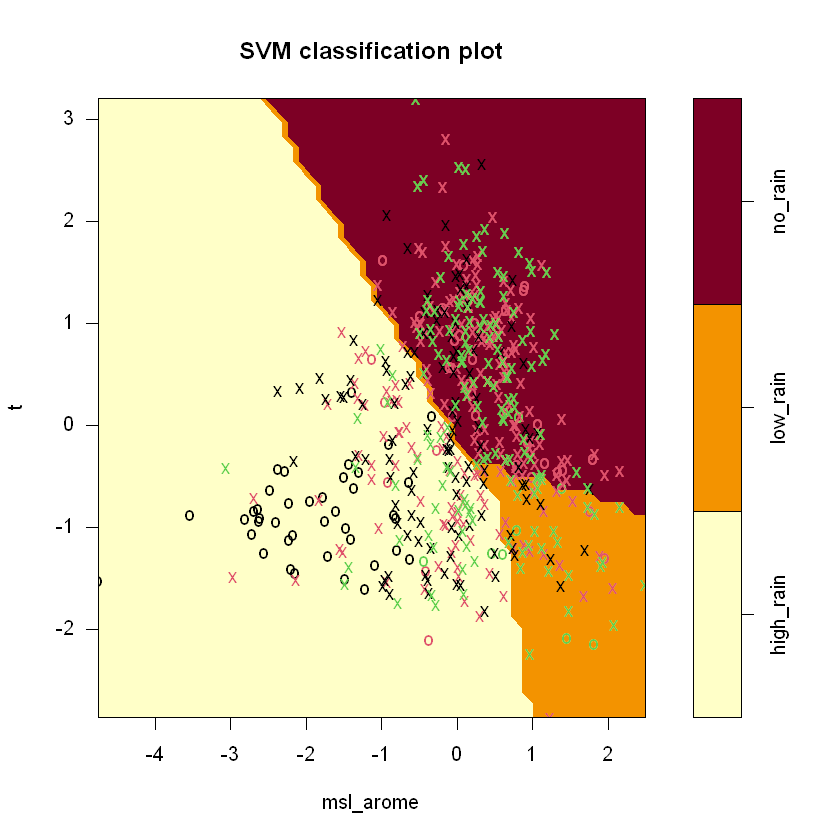

In [8]:
plot(linear.svm, data = train_set, t ~ msl_arome)

In [9]:
confusion_matrix(predict(linear.svm, newdata = train_set), y_train)

[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        83       21       7
  low_rain         64      190      95
  no_rain           8       23      59
[1] "Prediction accuracy :  0.603636363636364"


In [10]:
confusion_matrix(predict(linear.svm, newdata = test_set), y_test)

[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        21        9       7
  low_rain         11       41      26
  no_rain           1        8      14
[1] "Prediction accuracy :  0.550724637681159"


### Hyperparameter tuning

In [11]:
linear.svm.tune = tune.svm(rain_class ~ ., data = train_set, type = "C", kernel = 'linear', cost = seq(1, 100, by = 1))


In [12]:
summary(linear.svm.tune)


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost
   21

- best performance: 0.4490909 

- Detailed performance results:
    cost     error dispersion
1      1 0.4545455 0.03206971
2      2 0.4509091 0.03908973
3      3 0.4527273 0.03969581
4      4 0.4563636 0.03143346
5      5 0.4600000 0.02717153
6      6 0.4563636 0.03024236
7      7 0.4545455 0.03319531
8      8 0.4509091 0.03406902
9      9 0.4545455 0.03319531
10    10 0.4563636 0.03368956
11    11 0.4527273 0.03681538
12    12 0.4527273 0.03779992
13    13 0.4545455 0.03319531
14    14 0.4527273 0.02900239
15    15 0.4563636 0.03143346
16    16 0.4545455 0.03428397
17    17 0.4545455 0.03090315
18    18 0.4509091 0.03183982
19    19 0.4527273 0.03258104
20    20 0.4509091 0.03183982
21    21 0.4490909 0.03096252
22    22 0.4509091 0.03183982
23    23 0.4509091 0.03183982
24    24 0.4527273 0.03476274
25    25 0.4527273 0.03476274
26    26 0.4527273 0.03476274
27    27 0.4527273 

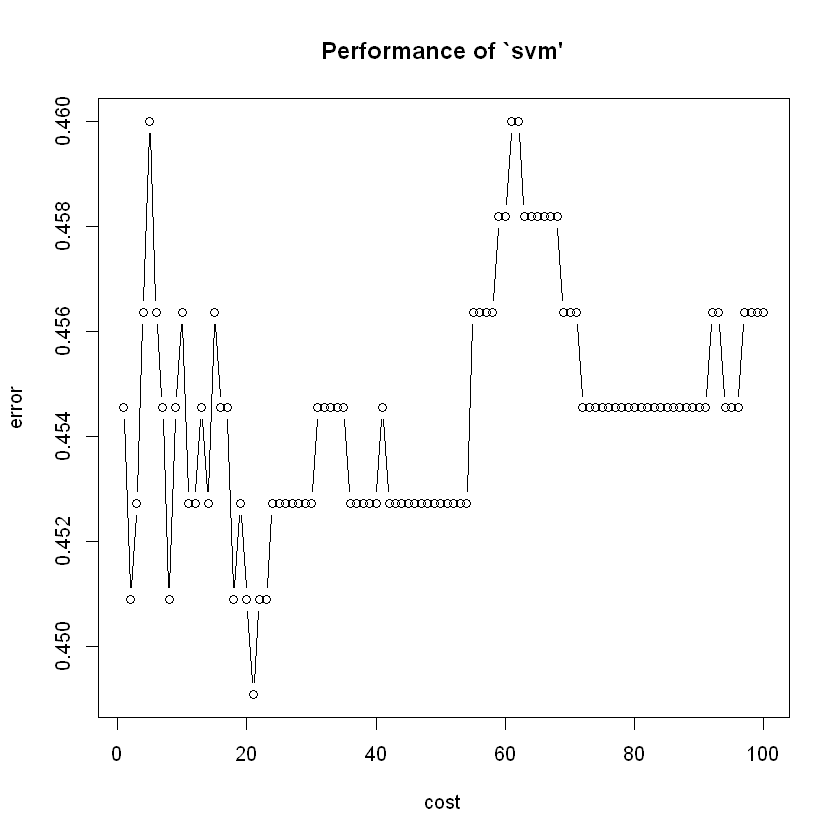

In [13]:
plot(linear.svm.tune)

In [14]:
linear.best.c = linear.svm.tune$best.parameters$cost
linear.best.c

[1] 21

In [15]:
linear.best.svm = svm(rain_class ~ ., data = train_set, type = "C", kernel = 'linear', cost = linear.best.c)
confusion_matrix(predict(linear.best.svm, newdata = train_set), y_train)


[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        83       23       7
  low_rain         64      186      89
  no_rain           8       25      65
[1] "Prediction accuracy :  0.607272727272727"


In [16]:
confusion_matrix(predict(linear.best.svm, newdata = test_set), y_test)


[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        21       11       6
  low_rain         11       41      26
  no_rain           1        6      15
[1] "Prediction accuracy :  0.557971014492754"


Not really good, we just get one more good prediction!

### 4.2. SVM with polynomial kernels

In [17]:
poly2.svm = svm(rain_class ~ ., data = train_set, type = "C", kernel = 'poly', gamma = 1., coef0 = 1., degree = 2, cost = 10)
summary(poly2.svm)


Call:
svm(formula = rain_class ~ ., data = train_set, type = "C", kernel = "poly", 
    gamma = 1, coef0 = 1, degree = 2, cost = 10)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  polynomial 
       cost:  10 
     degree:  2 
     coef.0:  1 

Number of Support Vectors:  373

 ( 158 97 118 )


Number of Classes:  3 

Levels: 
 high_rain low_rain no_rain




    There are less of support vectors than linear case

In [18]:
confusion_matrix(predict(poly2.svm, newdata = train_set), y_train)

[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain       155        0       0
  low_rain          0      233       1
  no_rain           0        1     160
[1] "Prediction accuracy :  0.996363636363636"


In [19]:
confusion_matrix(predict(poly2.svm, newdata = test_set), y_test)

[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        19       15       6
  low_rain         10       24      26
  no_rain           4       19      15
[1] "Prediction accuracy :  0.420289855072464"


    It seems that the model is overfit in the training set because the training accuracy is more than 99 percents meanwhile the test accuracy is just over 42 percents.

    We will use cross validation to determine the best hyperparameters

In [20]:
poly2.svm.tune = tune.svm(rain_class ~ ., data = train_set, type = "C", kernel = 'poly',
         gamma = seq(0.01, 0.1, by = 0.01), coef0 = 1., degree = 2, cost = seq(0.1, 1, by = 0.1))
summary(poly2.svm.tune)


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 degree gamma coef0 cost
      2   0.1     1  0.7

- best performance: 0.4563636 

- Detailed performance results:
    degree gamma coef0 cost     error dispersion
1        2  0.01     1  0.1 0.5109091 0.04806638
2        2  0.02     1  0.1 0.4963636 0.02975258
3        2  0.03     1  0.1 0.4836364 0.02993719
4        2  0.04     1  0.1 0.4727273 0.03090315
5        2  0.05     1  0.1 0.4690909 0.03066451
6        2  0.06     1  0.1 0.4600000 0.04024717
7        2  0.07     1  0.1 0.4672727 0.04203283
8        2  0.08     1  0.1 0.4690909 0.05056158
9        2  0.09     1  0.1 0.4745455 0.05174636
10       2  0.10     1  0.1 0.4800000 0.06251538
11       2  0.01     1  0.2 0.4963636 0.03837852
12       2  0.02     1  0.2 0.4872727 0.03183982
13       2  0.03     1  0.2 0.4672727 0.03212693
14       2  0.04     1  0.2 0.4600000 0.04024717
15       2  0.05     1  0.2 0.4709091 0.05103160
16     

In [21]:
poly2.svm.tune$best.parameters

,degree,gamma,coef0,cost
,<dbl>,<dbl>,<dbl>,<dbl>
70,2,0.1,1,0.7


In [22]:
poly2.best.c = poly2.svm.tune$best.parameters$cost
poly2.best.gamma = poly2.svm.tune$best.parameters$gamma
poly2.best.coef0 = poly2.svm.tune$best.parameters$coef0

In [23]:
poly2.best.svm = svm(rain_class ~ ., data = train_set, type = "C", kernel = 'poly', gamma = poly2.best.gamma,
                 coef0 = poly2.best.coef0, degree = 2, cost = poly2.best.c)

summary(poly2.best.svm)


Call:
svm(formula = rain_class ~ ., data = train_set, type = "C", kernel = "poly", 
    gamma = poly2.best.gamma, coef0 = poly2.best.coef0, degree = 2, 
    cost = poly2.best.c)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  polynomial 
       cost:  0.7 
     degree:  2 
     coef.0:  1 

Number of Support Vectors:  460

 ( 199 121 140 )


Number of Classes:  3 

Levels: 
 high_rain low_rain no_rain




In [24]:
confusion_matrix(predict(poly2.best.svm, newdata = train_set), y_train)
confusion_matrix(predict(poly2.best.svm, newdata = test_set), y_test)


[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain       111       22       4
  low_rain         36      192      64
  no_rain           8       20      93
[1] "Prediction accuracy :  0.72"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        20       15       8
  low_rain          8       32      24
  no_rain           5       11      15
[1] "Prediction accuracy :  0.485507246376812"


#### SVM with polynomial kernels of degree 3

In [25]:
poly3.svm = svm(rain_class ~ ., data = train_set, type = "C", kernel = 'poly', gamma = 0.5, coef0 = 0.5, degree = 3, cost = 0.5)
summary(poly3.svm)


Call:
svm(formula = rain_class ~ ., data = train_set, type = "C", kernel = "poly", 
    gamma = 0.5, coef0 = 0.5, degree = 3, cost = 0.5)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  polynomial 
       cost:  0.5 
     degree:  3 
     coef.0:  0.5 

Number of Support Vectors:  420

 ( 181 109 130 )


Number of Classes:  3 

Levels: 
 high_rain low_rain no_rain




    There are less of support vectors than linear case

In [26]:
confusion_matrix(predict(poly3.svm, newdata = train_set), y_train)

[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain       155        0       0
  low_rain          0      234       0
  no_rain           0        0     161
[1] "Prediction accuracy :  1"


In [27]:
confusion_matrix(predict(poly3.svm, newdata = test_set), y_test)

[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        20       17      10
  low_rain          8       24      26
  no_rain           5       17      11
[1] "Prediction accuracy :  0.398550724637681"




    We will use cross validation to determine the best hyperparameters

In [28]:
poly3.svm.tune = tune.svm(rain_class ~ ., data = train_set, type = "C", kernel = 'poly', gamma = seq(0.01, 0.1, by = 0.01), coef0 = seq(0.5, 1.5, by = 0.2), degree = 3, cost = seq(0.1, 2, by = 0.2))
summary(poly3.svm.tune)


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 degree gamma coef0 cost
      3  0.01   0.9  0.7

- best performance: 0.4636364 

- Detailed performance results:
    degree gamma coef0 cost     error dispersion
1        3  0.01   0.5  0.1 0.5418182 0.08732322
2        3  0.02   0.5  0.1 0.5000000 0.07820296
3        3  0.03   0.5  0.1 0.4890909 0.04957116
4        3  0.04   0.5  0.1 0.4818182 0.05437684
5        3  0.05   0.5  0.1 0.4818182 0.05160420
6        3  0.06   0.5  0.1 0.4800000 0.04787495
7        3  0.07   0.5  0.1 0.4800000 0.05762358
8        3  0.08   0.5  0.1 0.4709091 0.05174636
9        3  0.09   0.5  0.1 0.4763636 0.04519116
10       3  0.10   0.5  0.1 0.4927273 0.03969581
11       3  0.01   0.7  0.1 0.5290909 0.07295419
12       3  0.02   0.7  0.1 0.4854545 0.05074287
13       3  0.03   0.7  0.1 0.4800000 0.04787495
14       3  0.04   0.7  0.1 0.4800000 0.04938557
15       3  0.05   0.7  0.1 0.4818182 0.04474189
16     

In [29]:
poly3.svm.tune$best.parameters

,degree,gamma,coef0,cost
,<dbl>,<dbl>,<dbl>,<dbl>
201,3,0.01,0.9,0.7


In [30]:
poly3.best.c = poly3.svm.tune$best.parameters$cost
poly3.best.gamma = poly3.svm.tune$best.parameters$gamma
poly3.best.coef0 = poly3.svm.tune$best.parameters$coef0

In [31]:
poly3.best.svm = svm(rain_class ~ ., data = train_set, type = "C", kernel = 'poly', gamma = poly3.best.gamma,
                 coef0 = poly3.best.coef0, degree = 3, cost = poly3.best.c)

In [32]:
confusion_matrix(predict(poly3.best.svm, newdata = train_set), y_train)
confusion_matrix(predict(poly3.best.svm, newdata = test_set), y_test)

[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        76       17       8
  low_rain         76      210     125
  no_rain           3        7      28
[1] "Prediction accuracy :  0.570909090909091"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        17        9       7
  low_rain         16       48      35
  no_rain           0        1       5
[1] "Prediction accuracy :  0.507246376811594"


### 4.3. SVM with radial kernel

In [33]:
radial.svm = svm(rain_class ~ ., data = train_set, type = "C", kernel = 'radial', gamma = 0.5, cost = 0.5)
summary(radial.svm)


Call:
svm(formula = rain_class ~ ., data = train_set, type = "C", kernel = "radial", 
    gamma = 0.5, cost = 0.5)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  0.5 

Number of Support Vectors:  549

 ( 233 155 161 )


Number of Classes:  3 

Levels: 
 high_rain low_rain no_rain




    There are less of support vectors than linear case

In [34]:
confusion_matrix(predict(radial.svm, newdata = train_set), y_train)

[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        38        0       0
  low_rain        116      234     135
  no_rain           1        0      26
[1] "Prediction accuracy :  0.541818181818182"


In [35]:
confusion_matrix(predict(radial.svm, newdata = test_set), y_test)

[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain         0        0       0
  low_rain         33       57      47
  no_rain           0        1       0
[1] "Prediction accuracy :  0.41304347826087"


In [36]:
radial.svm.tune = tune.svm(rain_class ~ ., data = train_set, type = "C", kernel = 'radial', gamma = seq(0.01, 0.1, by = 0.01), cost = seq(0.1, 2, by = 0.1))
summary(radial.svm.tune)


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 gamma cost
  0.07  0.7

- best performance: 0.4454545 

- Detailed performance results:
    gamma cost     error dispersion
1    0.01  0.1 0.5327273 0.04289779
2    0.02  0.1 0.5127273 0.04908717
3    0.03  0.1 0.5072727 0.05103160
4    0.04  0.1 0.5127273 0.04678851
5    0.05  0.1 0.5254545 0.04150520
6    0.06  0.1 0.5600000 0.05056158
7    0.07  0.1 0.5745455 0.04551511
8    0.08  0.1 0.5763636 0.04539390
9    0.09  0.1 0.5745455 0.04551511
10   0.10  0.1 0.5745455 0.04551511
11   0.01  0.2 0.5090909 0.05283514
12   0.02  0.2 0.5036364 0.05557943
13   0.03  0.2 0.4927273 0.06439661
14   0.04  0.2 0.4963636 0.06301282
15   0.05  0.2 0.4981818 0.06759682
16   0.06  0.2 0.5054545 0.06459594
17   0.07  0.2 0.5072727 0.06608562
18   0.08  0.2 0.5072727 0.05778272
19   0.09  0.2 0.5236364 0.05541396
20   0.10  0.2 0.5363636 0.05369711
21   0.01  0.3 0.4981818 0.06132902
22   0.02  0.3 0.4909091 

In [37]:
radial.svm.tune$best.parameters

,gamma,cost
,<dbl>,<dbl>
67,0.07,0.7


In [38]:
radial.best.c = radial.svm.tune$best.parameters$cost
radial.best.gamma = radial.svm.tune$best.parameters$gamma
radial.best.coef0 = radial.svm.tune$best.parameters$coef0

In [39]:
radial.best.svm = svm(rain_class ~ ., data = train_set, type = "C", kernel = 'radial', gamma = radial.best.gamma, cost = radial.best.c)

In [40]:
confusion_matrix(predict(radial.best.svm, newdata = train_set), y_train)
confusion_matrix(predict(radial.best.svm, newdata = test_set), y_test)

[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        92       16       8
  low_rain         56      206      80
  no_rain           7       12      73
[1] "Prediction accuracy :  0.674545454545455"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        19       11       9
  low_rain         13       42      26
  no_rain           1        5      12
[1] "Prediction accuracy :  0.528985507246377"


### 4.3. SVM with sigmoid kernel

In [41]:
sigmoid.svm = svm(rain_class ~ ., data = train_set, type = "C", kernel = 'sigmoid', gamma = 1., coef0 = 1, cost = 10)
summary(sigmoid.svm)


Call:
svm(formula = rain_class ~ ., data = train_set, type = "C", kernel = "sigmoid", 
    gamma = 1, coef0 = 1, cost = 10)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  sigmoid 
       cost:  10 
     coef.0:  1 

Number of Support Vectors:  364

 ( 129 131 104 )


Number of Classes:  3 

Levels: 
 high_rain low_rain no_rain




    There are less of support vectors than linear case

In [42]:
confusion_matrix(predict(sigmoid.svm, newdata = train_set), y_train)

[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        26       21      12
  low_rain         75      123      92
  no_rain          54       90      57
[1] "Prediction accuracy :  0.374545454545455"


In [43]:
confusion_matrix(predict(sigmoid.svm, newdata = test_set), y_test)

[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain         8        5       3
  low_rain         18       33      26
  no_rain           7       20      18
[1] "Prediction accuracy :  0.427536231884058"


In [44]:
sigmoid.svm.tune = tune.svm(rain_class ~ ., data = train_set, type = "C", kernel = 'sigmoid', gamma = seq(0.5, 3, by = 0.5), cost = seq(5, 35, by = 5), coef0 = seq(0.5, 2, by = 0.5))
summary(sigmoid.svm.tune)


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 gamma coef0 cost
   2.5     1   10

- best performance: 0.5545455 

- Detailed performance results:
    gamma coef0 cost     error dispersion
1     0.5   0.5    5 0.5909091 0.06312929
2     1.0   0.5    5 0.5872727 0.07474474
3     1.5   0.5    5 0.5709091 0.05762358
4     2.0   0.5    5 0.5672727 0.08167215
5     2.5   0.5    5 0.5927273 0.07675704
6     3.0   0.5    5 0.5836364 0.07687658
7     0.5   1.0    5 0.6236364 0.07173566
8     1.0   1.0    5 0.5909091 0.04555544
9     1.5   1.0    5 0.5890909 0.04387142
10    2.0   1.0    5 0.5872727 0.06416805
11    2.5   1.0    5 0.5618182 0.06207315
12    3.0   1.0    5 0.5818182 0.07222046
13    0.5   1.5    5 0.6363636 0.05620375
14    1.0   1.5    5 0.5963636 0.02064168
15    1.5   1.5    5 0.5945455 0.04457740
16    2.0   1.5    5 0.5890909 0.05825753
17    2.5   1.5    5 0.5709091 0.06132902
18    3.0   1.5    5 0.5854545 0.07939163
19    0

In [45]:
sigmoid.svm.tune$best.parameters

,gamma,coef0,cost
,<dbl>,<dbl>,<dbl>
35,2.5,1,10


In [46]:
sigmoid.best.c = sigmoid.svm.tune$best.parameters$cost
sigmoid.best.gamma = sigmoid.svm.tune$best.parameters$gamma
sigmoid.best.coef0 = sigmoid.svm.tune$best.parameters$coef0

In [47]:
sigmoid.best.svm = svm(rain_class ~ ., data = train_set, type = "C", kernel = 'sigmoid', gamma = sigmoid.best.gamma, cost = sigmoid.best.c)

In [48]:
confusion_matrix(predict(sigmoid.best.svm, newdata = train_set), y_train)
confusion_matrix(predict(sigmoid.best.svm, newdata = test_set), y_test)

[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        47       44      26
  low_rain         88      139     102
  no_rain          20       51      33
[1] "Prediction accuracy :  0.398181818181818"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain         9        5       8
  low_rain         21       37      29
  no_rain           3       16      10
[1] "Prediction accuracy :  0.405797101449275"
